# LA Metro Bikeshare EDA
1. Story planning
2. Obtain data sets - D
3. Obtain lat longs with scraper
4. Clean data sets 
5. Feature engineering
6. Visualization
7. TBD

Is there a predictive value that can be derived for kinds of locations
    1. Finding lat long coordinates of schools or public services and mapping out color coded heat maps based on the type of establishment
    2. Finding out where most bike stations are likely to be located
    3. Goal is to find out where you would set up more bike locations + figure out why particular locations are popular and predict accordingly

In [11]:
# importing necessary packages
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import pprint
import missingno as msno
from urllib.request import Request, urlopen
import json
from bs4 import BeautifulSoup
import requests
import re
import numpy as np
import datetime
import math
import matplotlib.pyplot as plt
import seaborn as sb

# Core rides dataset

In [12]:
# there are 4 files for the data for each quarter from 2017 Q3 to 2018 Q2
_2017Q3 = pd.read_csv('../data/external/2017Q3.csv')
_2017Q4 = pd.read_csv('../data/external/2017Q4.csv')
_2018Q1 = pd.read_csv('../data/external/2018Q1.csv')
_2018Q2 = pd.read_csv('../data/external/2018Q2.csv')

In [13]:
# concatenate the four quarters of ride sharing data into a year's worth
rides_df = pd.concat([_2017Q3,_2017Q4,_2018Q1,_2018Q2])
rides_df.shape

(286295, 14)

In [14]:
rides_df.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type
0,33404951,36,7/1/2017 0:09,7/1/2017 0:45,3018,34.043732,-118.260139,3018,34.043732,-118.260139,5996,0,Round Trip,Walk-up
1,33404950,13,7/1/2017 0:10,7/1/2017 0:23,3055,34.044159,-118.251579,3082,34.046520,-118.237411,5777,0,One Way,Walk-up
2,33404947,34,7/1/2017 0:11,7/1/2017 0:45,3018,34.043732,-118.260139,3018,34.043732,-118.260139,6342,0,Round Trip,Walk-up
3,33404948,34,7/1/2017 0:11,7/1/2017 0:45,3018,34.043732,-118.260139,3018,34.043732,-118.260139,6478,0,Round Trip,Walk-up
4,33404949,12,7/1/2017 0:11,7/1/2017 0:23,3055,34.044159,-118.251579,3082,34.046520,-118.237411,6411,0,One Way,Walk-up


In [15]:
rides_df.describe()

,trip_id,duration,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration
count,2.862950e+05,286295.000000,286295.00000,285660.000000,285660.000000,286295.000000,281900.000000,281900.000000,286295.000000,286295.000000
mean,6.480957e+07,35.034206,3420.79971,34.045820,-118.271421,3414.716265,34.045689,-118.271667,7900.573014,30.907910
std,1.808223e+07,115.722913,538.47854,0.065529,0.097562,537.212309,0.065038,0.098157,2717.473129,66.243336
min,3.340494e+07,1.000000,3000.00000,33.710979,-118.491341,3000.000000,33.710979,-118.491341,4727.000000,0.000000
25%,4.905606e+07,7.000000,3031.00000,34.039982,-118.262733,3031.000000,34.039982,-118.262733,6053.000000,0.000000
50%,6.534754e+07,12.000000,3064.00000,34.046822,-118.252441,3063.000000,34.046810,-118.252830,6403.000000,30.000000
75%,8.085881e+07,25.000000,4156.00000,34.053200,-118.237411,4156.000000,34.051941,-118.237410,12019.000000,30.000000
max,9.508575e+07,1440.000000,4254.00000,34.165291,-118.116530,4254.000000,34.165291,-118.116530,12456.000000,365.000000


In [16]:
rides_df.dtypes

trip_id                  int64
duration                 int64
start_time              object
end_time                object
start_station            int64
start_lat              float64
start_lon              float64
end_station              int64
end_lat                float64
end_lon                float64
bike_id                  int64
plan_duration            int64
trip_route_category     object
passholder_type         object
dtype: object

On first glance, all time variables like start_time and end_time should be converted to a date time object.

In [17]:
# converting start and end times to datetime objects

rides_df['start_time'] = pd.to_datetime(rides_df['start_time'])
rides_df['end_time'] = pd.to_datetime(rides_df['end_time'])

In [18]:
# checking to see if columns were indeed converted
rides_df.dtypes

trip_id                         int64
duration                        int64
start_time             datetime64[ns]
end_time               datetime64[ns]
start_station                   int64
start_lat                     float64
start_lon                     float64
end_station                     int64
end_lat                       float64
end_lon                       float64
bike_id                         int64
plan_duration                   int64
trip_route_category            object
passholder_type                object
dtype: object

In [19]:
# quick look at which station is the most commonly used and where it is (Venice beach)
rides_df['start_station'].mode()

0    4214
dtype: int64

In [20]:
rides_df[rides_df['start_station'] == 4214].head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type
51390,44620579,16,2017-09-07 10:40:00,2017-09-07 10:56:00,4214,33.99556,-118.481552,4216,34.023392,-118.479637,11200,30,One Way,Monthly Pass
51391,44627346,28,2017-09-07 10:40:00,2017-09-07 11:08:00,4214,33.99556,-118.481552,4215,34.014309,-118.491341,12416,365,One Way,Flex Pass
51392,44641141,196,2017-09-07 10:40:00,2017-09-07 13:56:00,4214,33.99556,-118.481552,3000,NaN,NaN,12011,30,One Way,Monthly Pass
51393,44641142,167,2017-09-07 10:40:00,2017-09-07 13:27:00,4214,33.99556,-118.481552,4212,33.988129,-118.471741,12241,365,One Way,Flex Pass
51394,44620577,17,2017-09-07 10:41:00,2017-09-07 10:58:00,4214,33.99556,-118.481552,4215,34.014309,-118.491341,12356,30,One Way,Monthly Pass


Here we use the missingno package to check for NA values in the dataframe. As the number of missing values seem almost negligible compared to the total number of observations, we drop the rows. Around 4849 rows, or 1.7% of total rows were dropped.

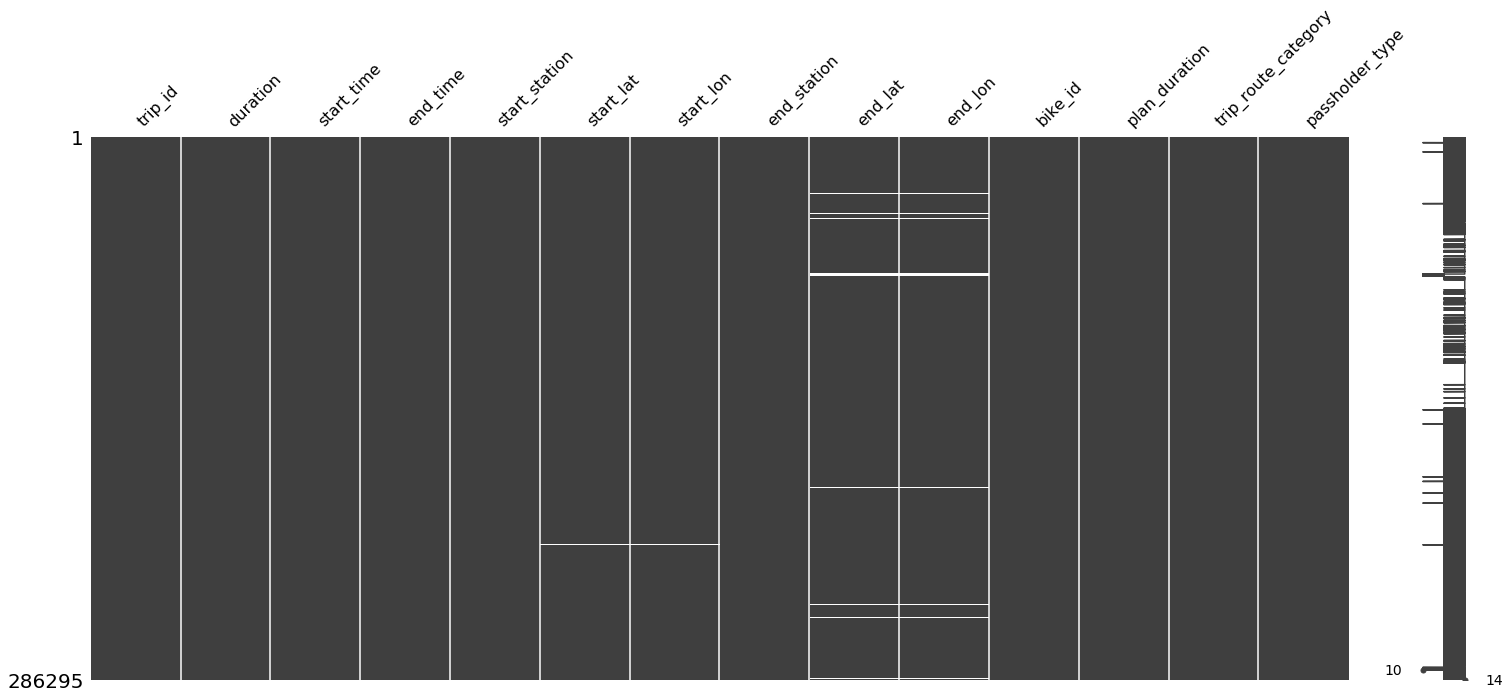

In [21]:
# check for missing values
%matplotlib inline
msno.matrix(rides_df)

In [22]:
# dropping rows with na values
rides_df = rides_df.dropna()
rides_df.shape

(281446, 14)

# External datasets of geolocations

In order to obtain a perspective of where most rides occur and landmarks around LA, we utilize multiple data sources and APIs to obtain the relevant latitude and longitude values.

### Bike station locations
We first start off with more detailed information on the bike stations. To do this, we download the json file from https://bikeshare.metro.net/stations/json/ which includes addresses and capacities of different bike stations.

In [23]:
# read in the json file with station information
with open ('../data/external/bike_stations.json') as f:
    station_data = json.load(f)

In [24]:
# extract useful columns from the jason and append it to a list
all_station_info = []
for station in station_data['features']: 
    station_attr = []
    station_attr.append([station['properties']['kioskId'], station['properties']['addressStreet'], 
                         station['properties']['addressZipCode'], station['properties']['name'],
                         station['properties']['totalDocks']])
    all_station_info.append(station_attr[0])

In [25]:
# check to see if each element in list is a list of station attributes we need
all_station_info[2]

[3007, '557 S 5th Street', '90071', '5th & Grand', 23]

In [26]:
# create new dataframe based on the attributes
stations_info = pd.DataFrame(all_station_info, columns=['kiosk_id','address_street','address_zip','station_name','total_docks'])
stations_info.head()

,kiosk_id,address_street,address_zip,station_name,total_docks
0,3005,723 Flower Street,90017,7th & Flower,27
1,3006,729 S Olive Street,90014,Olive & 8th,24
2,3007,557 S 5th Street,90071,5th & Grand,23
3,3008,865 S Figueroa Street,90017,Figueroa & 9th,15
4,3010,401 East 11th Street,90015,11th & Maple,22


In [27]:
# adding start station attributes
rides_df = pd.merge(rides_df, stations_info, how = "left", left_on = 'start_station', 
               right_on = ['kiosk_id']).rename(columns = {'address_street':'start_address',
                                                          'address_zip':'start_zip','station_name':'start_name',
                                                          'total_docks':'start_docks'}).drop('kiosk_id',1)
# adding end station attributes
rides_df = pd.merge(rides_df, stations_info, how = "left", left_on = 'end_station', 
               right_on = ['kiosk_id']).rename(columns = {'address_street':'end_address',
                                                          'address_zip':'end_zip','station_name':'end_name',
                                                          'total_docks':'end_docks'}).drop('kiosk_id',1)

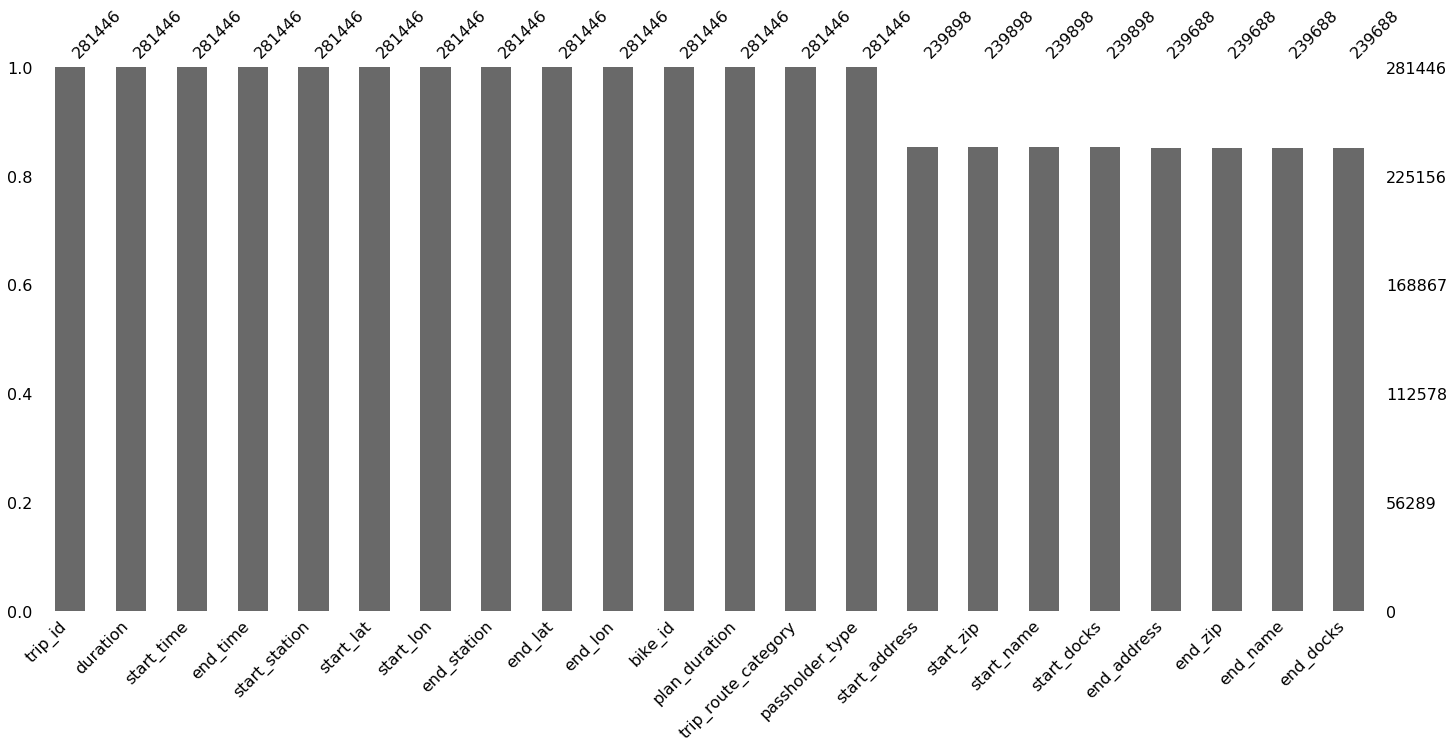

In [28]:
# checking for missing address details
msno.bar(rides_df)

There seems to be about 20% of entries with missing station information. As this is a sizeable portion of the dataset, we can take a closer look to see how to deal with these missing values.

In [29]:
rides_df['start_station'].value_counts().describe()

count      124.000000
mean      2269.725806
std       2154.035881
min          6.000000
25%        804.500000
50%       1544.500000
75%       3019.500000
max      11437.000000
Name: start_station, dtype: float64

In [30]:
rides_df['start_docks'].describe()

count    239898.000000
mean         22.869882
std           5.119422
min          13.000000
25%          19.000000
50%          22.000000
75%          27.000000
max          36.000000
Name: start_docks, dtype: float64

In [31]:
median_mask = rides_df[rides_df.isnull().any(axis = 1)]['start_station'].value_counts() > rides_df['start_station'].value_counts().median()
locations_to_fill = rides_df[rides_df.isnull().any(axis = 1)]['start_station'].value_counts()[median_mask]
locations_to_fill.keys()

Int64Index([4162, 4153, 4181, 4165, 4176, 4142, 4157, 4180, 4163, 4159, 4177], dtype='int64')

In [32]:
str(round(locations_to_fill.sum()/rides_df[rides_df.isnull().any(axis = 1)]['start_station'].value_counts().sum(),2)*100) + '%'

'47.0%'

In [33]:
lats = []
longs = []
for station_id in locations_to_fill.keys():
    lats.append(rides_df['start_lat'][rides_df['start_station'] == station_id].iloc[0])
    longs.append(rides_df['start_lon'][rides_df['start_station'] == station_id].iloc[0])

In [34]:
manual_add_cols = list(stations_info.columns)
manual_add_cols.extend(('start_lat','start_lon'))
manual_add_cols[0] = 'start_station'
manual_kiosk_add = pd.DataFrame(columns = manual_add_cols)
manual_kiosk_add['start_station'] = np.asarray(locations_to_fill.keys())
manual_kiosk_add['end_station'] = manual_kiosk_add['start_station']
manual_kiosk_add['start_lat'] = np.asarray(lats)
manual_kiosk_add['start_lon'] = np.asarray(longs)
manual_kiosk_add

,start_station,address_street,address_zip,station_name,total_docks,start_lat,start_lon,end_station
0,4162,NaN,NaN,NaN,NaN,34.147499,-118.148010,4162
1,4153,NaN,NaN,NaN,NaN,34.156181,-118.166687,4153
2,4181,NaN,NaN,NaN,NaN,34.146221,-118.135262,4181
3,4165,NaN,NaN,NaN,NaN,34.141750,-118.149063,4165
4,4176,NaN,NaN,NaN,NaN,34.137859,-118.122414,4176
5,4142,NaN,NaN,NaN,NaN,34.144588,-118.144592,4142
6,4157,NaN,NaN,NaN,NaN,34.140999,-118.132088,4157
7,4180,NaN,NaN,NaN,NaN,34.137951,-118.128502,4180
8,4163,NaN,NaN,NaN,NaN,34.150471,-118.132019,4163
9,4159,NaN,NaN,NaN,NaN,34.145901,-118.116539,4159


In [35]:
manual_street_addresses = []
manual_zips = []
manual_names = []
manual_street_addresses.extend(('136 E Holly St','1001 Rose Bowl Dr','2-26 N Oak Knoll Ave','272-260 S Raymond Ave', '1320-1342 San Pasqual St', '300 E Green St', '270 S Lake Ave', '1085-1041 San Pasqual St', '300 N Lake Ave','1570 E Colorado Blvd','50 S Madison Ave'))
manual_zips.extend((91103, 91103, 91101, 91105, 91106, 91101, 91101, 91106, 91101, 91106, 91101))
manual_names.extend(('Memorial Park Station', 'Rose Bowl Stadium', 'E Colorado Blvd Target','Central Park','Caltech Student Services','Pasadena Civic Auditorium', 'The Shops on Lake Avenue','Caltech Graduate Housing', 'Gateway Plaza', 'Pasadena City College Shatford Library', 'Playhouse parking lot'))

In [36]:
manual_kiosk_add['address_street'] = np.asarray(manual_street_addresses)
manual_kiosk_add['address_zip'] = np.asarray(manual_zips)
manual_kiosk_add['station_name'] = np.asarray(manual_names)
manual_kiosk_add = manual_kiosk_add.fillna(22)

manual_kiosk_add

,start_station,address_street,address_zip,station_name,total_docks,start_lat,start_lon,end_station
0,4162,136 E Holly St,91103,Memorial Park Station,22,34.147499,-118.148010,4162
1,4153,1001 Rose Bowl Dr,91103,Rose Bowl Stadium,22,34.156181,-118.166687,4153
2,4181,2-26 N Oak Knoll Ave,91101,E Colorado Blvd Target,22,34.146221,-118.135262,4181
3,4165,272-260 S Raymond Ave,91105,Central Park,22,34.141750,-118.149063,4165
4,4176,1320-1342 San Pasqual St,91106,Caltech Student Services,22,34.137859,-118.122414,4176
5,4142,300 E Green St,91101,Pasadena Civic Auditorium,22,34.144588,-118.144592,4142
6,4157,270 S Lake Ave,91101,The Shops on Lake Avenue,22,34.140999,-118.132088,4157
7,4180,1085-1041 San Pasqual St,91106,Caltech Graduate Housing,22,34.137951,-118.128502,4180
8,4163,300 N Lake Ave,91101,Gateway Plaza,22,34.150471,-118.132019,4163
9,4159,1570 E Colorado Blvd,91106,Pasadena City College Shatford Library,22,34.145901,-118.116539,4159


In [37]:
# function to use the df.where function to map values to original dataframe
def fill_df_null(df1, df2, target_col, common_col, alt_name):
    df1[target_col] = df1[target_col].where(df1[target_col].notnull(), 
                                           df1[common_col].map(df2.set_index(common_col)[alt_name]))

fill_df_null(rides_df, manual_kiosk_add, 'start_address', 'start_station', 'address_street')
fill_df_null(rides_df, manual_kiosk_add, 'start_zip', 'start_station', 'address_zip')
fill_df_null(rides_df, manual_kiosk_add, 'start_name', 'start_station', 'station_name')
fill_df_null(rides_df, manual_kiosk_add, 'start_docks', 'start_station', 'total_docks')

fill_df_null(rides_df, manual_kiosk_add, 'end_address', 'end_station', 'address_street')
fill_df_null(rides_df, manual_kiosk_add, 'end_zip', 'end_station', 'address_zip')
fill_df_null(rides_df, manual_kiosk_add, 'end_name', 'end_station', 'station_name')
fill_df_null(rides_df, manual_kiosk_add, 'end_docks', 'end_station', 'total_docks')

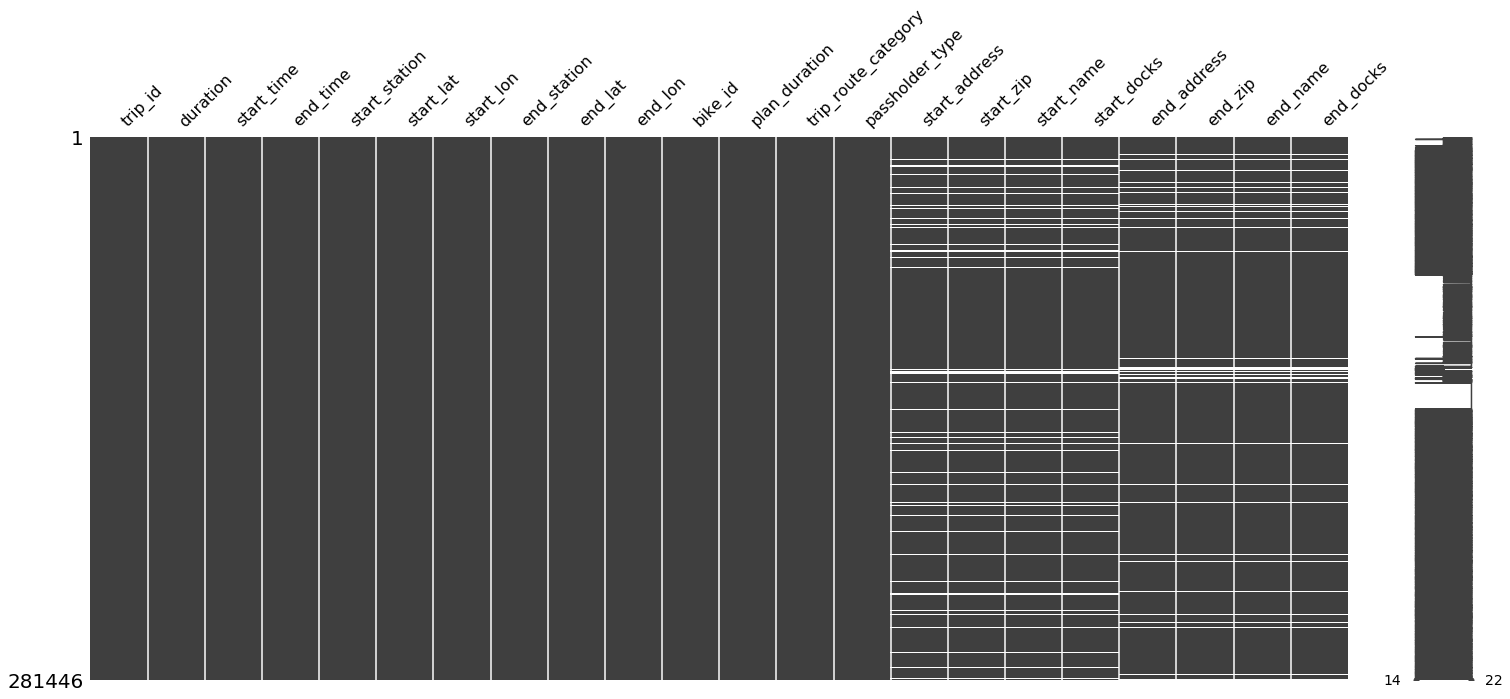

In [38]:
msno.matrix(rides_df)

In [39]:
rides_df = rides_df.dropna()

In [40]:
rides_df.shape

(250513, 22)

In [41]:
# create label for rides that were charged based on current pricing plan
def label_charged(duration):
    if duration <= 30:
        return 0
    else:
        return 1
    
rides_df['charged_ride'] = rides_df['duration'].apply(label_charged)

In [42]:
# hour of day of ride
rides_df['start_hour'] = rides_df['start_time'].dt.hour

In [43]:
latest_ride_date = rides_df['end_time'].max()
latest_ride_date

Timestamp('2018-07-02 00:09:00')

In [44]:
bike_last_used_id = bike_last_used = rides_df.groupby('bike_id')['end_time'].max().keys().tolist()
bike_last_used_date = rides_df.groupby('bike_id')['end_time'].max().tolist()

In [45]:
# number of bikes active each month in the past year
# 11 months back was when Bird officially launched in LA
for month in range(1,13):
    print(month, len([record for record in list(zip(bike_last_used_id,bike_last_used_date)) if record[1] > latest_ride_date + np.timedelta64(-month, 'M') ]))

1 1259
2 1353
3 1383
4 1409
5 1415
6 1419
7 1427
8 1436
9 1442
10 1445
11 1448
12 1452


In [46]:
# number of inactive bikes (bikes that haven't been used in the past 6 months)
len([record for record in list(zip(bike_last_used_id,bike_last_used_date)) if record[1] < latest_ride_date + np.timedelta64(-6, 'M') ])

33

In [47]:
inactive_ids = [record[0] for record in list(zip(bike_last_used_id,bike_last_used_date)) if record[1] < latest_ride_date + np.timedelta64(-6, 'M') ]

In [48]:
# feature indicating active bikes, used in past 6 months
rides_df['active_6m'] = rides_df['bike_id'].apply(lambda bike_id: 0 if bike_id in (inactive_ids) else 1)

In [49]:
rides_df['passholder_type'].unique()

array(['Walk-up', 'Monthly Pass', 'Flex Pass', 'One Day Pass'], dtype=object)

In [50]:
one_hot_pass = pd.get_dummies(rides_df['passholder_type']).rename(columns={
    'Flex Pass' : 'annual',
    'Monthly Pass' : 'monthly',
    'One Day Pass' : 'one_day',
    'Walk-up' : 'walk_up'
})

one_hot_trip_type = pd.get_dummies(rides_df['trip_route_category']).rename(columns = {
    'One Way' : 'one_way',
    'Round Trip' : 'round_trip'
})

rides_df = rides_df.join([one_hot_pass, one_hot_trip_type])
rides_df.head(10)

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_address,start_zip,start_name,start_docks,end_address,end_zip,end_name,end_docks,charged_ride,start_hour,active_6m,annual,monthly,one_day,walk_up,one_way,round_trip
0,33404951,36,2017-07-01 00:09:00,2017-07-01 00:45:00,3018,34.043732,-118.260139,3018,34.043732,-118.260139,5996,0,Round Trip,Walk-up,919 S Grand Ave,90015,Grand & Olympic,22.0,919 S Grand Ave,90015,Grand & Olympic,22.0,1,0,1,0,0,0,1,0,1
1,33404950,13,2017-07-01 00:10:00,2017-07-01 00:23:00,3055,34.044159,-118.251579,3082,34.046520,-118.237411,5777,0,One Way,Walk-up,111 W 7th Street,90014,7th & Main,23.0,599 Traction Ave,90013,Traction & Rose,27.0,0,0,1,0,0,0,1,1,0
2,33404947,34,2017-07-01 00:11:00,2017-07-01 00:45:00,3018,34.043732,-118.260139,3018,34.043732,-118.260139,6342,0,Round Trip,Walk-up,919 S Grand Ave,90015,Grand & Olympic,22.0,919 S Grand Ave,90015,Grand & Olympic,22.0,1,0,1,0,0,0,1,0,1
3,33404948,34,2017-07-01 00:11:00,2017-07-01 00:45:00,3018,34.043732,-118.260139,3018,34.043732,-118.260139,6478,0,Round Trip,Walk-up,919 S Grand Ave,90015,Grand & Olympic,22.0,919 S Grand Ave,90015,Grand & Olympic,22.0,1,0,1,0,0,0,1,0,1
4,33404949,12,2017-07-01 00:11:00,2017-07-01 00:23:00,3055,34.044159,-118.251579,3082,34.046520,-118.237411,6411,0,One Way,Walk-up,111 W 7th Street,90014,7th & Main,23.0,599 Traction Ave,90013,Traction & Rose,27.0,0,0,1,0,0,0,1,1,0
5,33404946,18,2017-07-01 00:12:00,2017-07-01 00:30:00,3047,34.039982,-118.266403,3005,34.048500,-118.258537,5778,0,One Way,Walk-up,515 W Pico Street,90015,Pico & Flower,36.0,723 Flower Street,90017,7th & Flower,27.0,0,0,1,0,0,0,1,1,0
6,33404945,23,2017-07-01 00:20:00,2017-07-01 00:43:00,3067,34.045181,-118.250237,3055,34.044159,-118.251579,5901,30,One Way,Monthly Pass,640 S Spring Street,90014,Main & 6th,19.0,111 W 7th Street,90014,7th & Main,23.0,0,0,1,0,1,0,0,1,0
7,33404944,3,2017-07-01 00:24:00,2017-07-01 00:27:00,3005,34.048500,-118.258537,3051,34.045422,-118.253517,5905,30,One Way,Monthly Pass,723 Flower Street,90017,7th & Flower,27.0,307 W 7th Street,90014,7th & Broadway,16.0,0,0,1,0,1,0,0,1,0
8,33404943,4,2017-07-01 00:32:00,2017-07-01 00:36:00,3046,34.053020,-118.247948,3062,34.047749,-118.243172,6254,30,One Way,Monthly Pass,201 South Hill Street,90021,2nd & Hill,17.0,350 E Third Street,90013,3rd & San Pedro,27.0,0,0,1,0,1,0,0,1,0
9,33404942,8,2017-07-01 00:33:00,2017-07-01 00:41:00,3038,34.046822,-118.248352,3038,34.046822,-118.248352,6176,30,Round Trip,Monthly Pass,458 S Main Street,90013,Main & 5th,18.0,458 S Main Street,90013,Main & 5th,18.0,0,0,1,0,1,0,0,0,1


In [51]:
# Walk-up  3.50/30minutesAlltrips30minutesorlessare3.50/30minutesAlltrips30minutesorlessare 3.50 
# $3.50 per 30 minutes thereafter
# Find a Station One Day Pass  7/dayAlltrips30minutesorlessarefree7/dayAlltrips30minutesorlessarefree 
# 1.75 per 30 minutes thereafter
# Buy a Pass Monthly Pass  20/monthAlltrips30minutesorlessarefree20/monthAlltrips30minutesorlessarefree 
# 1.75 per 30 minutes thereafter
# determining pricing based on the following scheme:

In [52]:
rides_df[rides_df['passholder_type'] == 'Flex Pass'].iloc[1]

trip_id                                   33463066
duration                                        18
start_time                     2017-07-01 11:34:00
end_time                       2017-07-01 11:52:00
start_station                                 3011
start_lat                                  34.0411
start_lon                                 -118.268
end_station                                   3062
end_lat                                    34.0477
end_lon                                   -118.243
bike_id                                       6634
plan_duration                                  365
trip_route_category                        One Way
passholder_type                          Flex Pass
start_address          1259-1299 S Figueroa Street
start_zip                                    90015
start_name                         Figueroa & Pico
start_docks                                     19
end_address                     350 E Third Street
end_zip                        

In [53]:
rides_df.shape

(250513, 31)

In [182]:
# create variable for 30 minute blocks that all users have to pay for, excluding first 30 minutes
rides_df['time_block_count'] = rides_df['duration'].apply(lambda duration: math.ceil(duration/30))
rides_df['time_block_count_post_free'] = rides_df['duration'].apply(lambda duration: math.ceil(duration/30)) - 1

In [55]:
print('Dates range from: ', rides_df['start_time'].min(), ' to ', rides_df['start_time'].max())

Dates range from:  2017-07-01 00:09:00  to  2018-06-30 23:52:00


### Potential EDA:
1. Planning inventory around locations and time
    1. Most common start, end station pairings
    2. Most common time periods
    3. Different heatmaps for different time periods
    4. Start/end station correlation with available docks at location
2. Pricing strategies for different passes
    1. Usage rates across different passes
        1. By duration
        2. By number of trips
        3. Total duration X trips
    2. Geographical gropuing of where most passes originate/end from
    3. Cohort analysis of different groups
    4. How many rides were past the free 30 minute mark?
3. Unit pricing strategies, what if we brought it back? Charging all > 
    1. Based on current pricing strategy, what would total revenue be on a per mile basis
    2. Comparison with Bird/Jump bike pricing
    3. Cohort analysis of different groups
    4. Optimization function for 2 and 3

Pricing strategies can be used to build predictor model for rides, duration, and total revenue

### Feature engineering
1. Hours
2. Free ride with pass? (>30 in time or not)
3. Active or none active bikes (whether they've been used in the past month)
4. Number of 30 minute blocks
5. One hot encoding pass type
6. One hot encoding route type (one way, round trip)

### Current pricing

Walk up   
$ 1.75 for each 30 min trip   
$ 1.75 per 30 minutes thereafter

Day Pass 
$5/day
All rides 30 minutes or less are free
$1.75 per 30 minutes thereafter
 

Sign Up
Monthly Pass
$17/month
All rides 30 minutes or less are free
$1.75 per 30 minutes thereafter
 

Sign Up
Annual Pass
$150/year
Equivalent to $12.50/month
All rides 30 minutes or less are free
$1.75 per 30 minutes thereafter

### Previous pricing

Walk-up
$3.50/30 minutes
All trips 30 minutes or less are $3.50
$3.50 per 30 minutes thereafter
 

Find a Station
One Day Pass
$7/day
All trips 30 minutes or less are free
$1.75 per 30 minutes thereafter


Buy a Pass
Monthly Pass
$20/month
All trips 30 minutes or less are free
$1.75 per 30 minutes thereafter

Buy a Pass
Annual Pass
$150/year
All trips 30 minutes or less are free
$1.75 per 30 minutes thereafter

### Competitor pricing:

Bird Scooters - $.15 per minute   

Lime Pedal Bikes - $1 to unlock + $0.05/minute to ride.   

Lime-E Electric Assist Bikes - $1 to unlock +  $.15 per minute   

Lime-S Electric Scooters - $1 to unlock + $.15 per minute   

LimePrime - $29.95 per month and includes $100 in ride credits for use on Lime Classic Pedal Bikes only.   

LimePrime Students is $14.95 per month and includes 100 ride credits, with a valid ".EDU" email address. Students, faculty and staff all qualify.   

JUMP Bikes (& scooters) (Santa Monica only) - $1 for first 5 minutes + $.15 per minute after   

JUMP Bikes (& scooters) Boost Plan (Santa Monica only) - $5 a month for 60 minutes a day of ride time + .07 after 60 min.

## Optimization models

As seen from competitors, there are multiple ways in which the pricing scheme can be structure. Some options that we could implement and compare are as follows:
1. Variable rate by minute
2. Variable rate by time intervals (30 minutes for LA Metro currently)
3. Fixed fee for any ride
4. Fixed fee for a time interval before implementing a variable rate
5. Weekly, monthly passes that cover all rides up to a particular duration. Variable rate thereafter

We will examine the current model by LA metro and whether the current level of customer segmentation is necessary. To benchmark the pricing against other operators of bikes and scooters, let's plot out the different pricing curves for all operators.

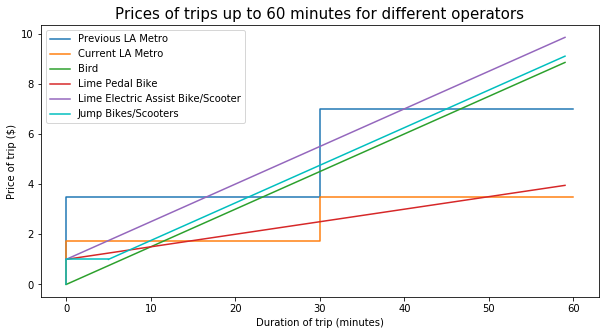

In [180]:
fig, axes = plt.subplots(figsize=(10,5))
x = np.array(range(0,60))
prev_la, = plt.step([0,30,60], [0,3.5,7], label = 'Previous LA Metro')
cur_la, = plt.step([0,30,60], [0,1.75,3.5], label = 'Current LA Metro')
bird, = plt.plot(x, 0.15 * x, label = 'Bird')
lime_ped, = plt.plot(x, 1 + 0.05 * x, label = 'Lime Pedal Bike')
lime_scoot, = plt.plot(x, 1 + 0.15 * x, label = 'Lime Electric Assist Bike/Scooter')
jump1, = plt.step([0,5],[0,1],label = 'Jump Bikes/Scooters',color = 'c')
jump2, = plt.plot(np.array(range(5,60)), 0.15 * np.array(range(5,60)) + 0.25, color = 'c')
plt.title('Prices of trips up to 60 minutes for different operators', size=15)
plt.xlabel('Duration of trip (minutes)')
plt.ylabel('Price of trip ($)')
plt.legend()
plt.show()

Looking at the different pricing schemes across bike and scooter operators in LA, the current pricing that was just enacted by LA Metro is definitely the cheapest, coming in at $3.50 for an hour long bike ride.

The previous pricing for an hour long bike ride for a walk-on was $7, twice the current price.

The next cheapest option is the Lime pedal bike, which is cheaper than walk on riders on LA metro for rides shorter than 15 minutes and for rides between 30 and 50 minutes. 

We will thus formulate the following linear constraints to optimize total revenue for the current pricing structure:   
1. The variable rate per minute without a pass is set under the average of the two most common prices of \$0.05 and \$0.15:    
Variable rate per minute without pass <= \$0.10
2. The variable rate per minute with a plan is set under the average of the LA Metro's current ~\$0.06 and Jump's \$0.07:   
Variable rate per minute with pass <= \$0.65 
3. The variable rate is set under the nearest competitor(Lime pedal):   
Variable rate per 30 minutes <= \$2.5
4. As there aren't many operators out there with comparable pass pricing plans, we maintain the current prices of 5, 17, and 150 for daily pass, monthly pass, and annual pass respectively:      
Daily pass price <= \$5   
Monthly pass price <= \$17   
Annual pass price <= \$150

In [219]:
pass_groups = rides_df.groupby('passholder_type')
pass_groups.groups.keys()

dict_keys(['Flex Pass', 'Monthly Pass', 'One Day Pass', 'Walk-up'])

In [221]:
average_ride = 
agg_pass_groups = pass_groups.agg({
    'trip_id' : 'count',
    'walk_up' : 'sum',
    'time_block_count' : 'sum',
    'time_block_count_post_free' : 'sum',
    'duration' : 'sum'
}).rename(columns = {
    'trip_id' : 'total_trips',
    'walk_up' : 'pay_count_walk_up',
    'time_block_count' : 'total_30min_blocks',
    'time_block_count_post_free' : 'total_30min_blocks_post_free',
    'duration' : 'total_minutes'
}).reset_index()
agg_pass_groups['passholder_type'] = ['annual','monthly','daily','walk_up']
agg_pass_groups.index = agg_pass_groups['passholder_type']
agg_pass_groups = agg_pass_groups.drop('passholder_type',1)
agg_pass_groups

,total_trips,pay_count_walk_up,total_30min_blocks,total_30min_blocks_post_free,total_minutes
passholder_type,,,,,
annual,9175,0.0,10858,1683,143708
monthly,146531,0.0,165592,19061,1982585
daily,14640,0.0,38517,23877,937578
walk_up,80167,80167.0,178895,98728,4158810


We are however missing the number of passholders to implement revenue gained from selling passes. As we do not have unique identifiers for passholders, we refer to the data page of LA Metro bikes here: https://bikeshare.metro.net/about/data/.

With roughly 575,281 trips completed and 42,870 passes sold since it's inception in July 2016, it would be safe to expect roughly 20,000 passholders during the year-long period of this analysis. 

We will estimate the number of different passholders with a breakeven perspective. As most trips (>60%) are "last mile" trips from metro stops and the median duration of trips is 12 minutes, we conduct the following breakeven analysis for trips under 30 minutes.

In [245]:
# average difference between passholders and walk-up riders across previous and current pricing
price_diff = (3.5 + 1.75)/2

# average prices of respective plans across previous and current pricing
day_price = (5 + 7)/2
month_price = (17 + 20)/2
annual_price = (150 + 150)/2

# number of rides for breakeven for day pass, in rides/day
rides_per_day = day_price/price_diff

# number of rides for breakeven for month pass, in rides/month
rides_per_month = month_price/price_diff

# number of rides for breakeven for annual pass, in rides/year
rides_per_year = annual_price/price_diff

print("Rides per day required for daily pass:",rides_per_day,'\n', 
      "Rides per month required for monthly pass:", rides_per_month,'\n', 
      "Rides per year required for annual pass:", rides_per_year)

Rides per day required for daily pass: 2.2857142857142856 
 Rides per month required for monthly pass: 7.0476190476190474 
 Rides per year required for annual pass: 57.142857142857146


In [253]:
# divide total trips by rides required for breakeven per pass duration (day/month/year) to get estimated number
# of passholders
passholders_day = math.ceil(agg_pass_groups.loc['daily','total_trips']/rides_per_day)
passholders_month = math.ceil(agg_pass_groups.loc['monthly','total_trips']/rides_per_month)
passholders_annual = math.ceil(agg_pass_groups.loc['annual','total_trips']/rides_per_year)

agg_pass_groups['passholders'] = [passholders_annual, passholders_month, passholders_day, 0]

print("Estimated passholders for daily pass:",passholders_day,'\n', 
      "Estimated passholders for monthly pass:", passholders_month,'\n', 
      "Estimated passholders for annual pass:", passholders_annual,'\n',
     "Total passholders:", passholders_day + passholders_month + passholders_annual)

Estimated passholders for daily pass: 6405 
 Estimated passholders for monthly pass: 20792 
 Estimated passholders for annual pass: 161 
 Total passholders: 27358


The total number of estimated passes bought during this period is around 27,358. This seems slightly on the high side though still within the realm of possibility. 

A quick calculation would yield estimated total revenue from just selling passes at around $ 447,000.

For the following analyses, we assume that number of passholders stay constant. In other words, passholders remain in their pass type and purchase it at the same rate

Lets now formulate the objective function for this optimization model to maximum total revenue from pass sales and rides.

The total revenue can be split into the following:
1. Total revenue from walk up users = Price for 30 minutes of usage * Total 30 minute blocks by walk up users
2. Total revenue from pass users = Price for 30 minutes of usage * Total 30 minute blocks after free first 30 minutes
3. Total revenue from selling passes = Prices of respective passes * Total passholders in respective pass types

Now we can represent this objective function in PuLP.

In [353]:
agg_pass_groups['pass_prices'] = [annual_price, month_price, day_price, 0]
agg_pass_groups

,total_trips,pay_count_walk_up,total_30min_blocks,total_30min_blocks_post_free,total_minutes,passholders,pass_prices
passholder_type,,,,,,,
annual,9175,0.0,10858,1683,143708,161,150.0
monthly,146531,0.0,165592,19061,1982585,20792,18.5
daily,14640,0.0,38517,23877,937578,6405,6.0
walk_up,80167,80167.0,178895,98728,4158810,0,0.0


In [399]:
from pulp import *

In [400]:
model = pulp.LpProblem("Revenue Maximization v1", pulp.LpMaximize)

In [401]:
# list of all pricing variables
# price_minute = pulp.LpVariable('price_minute', lowBound = 0, upBound = 0.65,cat='Continuous')
# price_block = pulp.LpVariable('price_block', lowBound = 0, upBound = 2.5,cat='Continuous')
upper_minute_price = 0.65
upper_block_price = 2.5

In [402]:
# list of all binary variables
by_minute = pulp.LpVariable('by_minute', cat='Binary')

by_block = pulp.LpVariable('by_block', cat='Binary')

day_yes = pulp.LpVariable('day_yes', cat='Binary')

day_no = pulp.LpVariable('day_no', cat='Binary')

month_yes = pulp.LpVariable('month_yes', cat='Binary')

month_no = pulp.LpVariable('month_no', cat='Binary')

annual_yes = pulp.LpVariable('annual_yes', cat='Binary')

annual_no = pulp.LpVariable('annual_no', cat='Binary')

In [403]:
# objective function
# revenue for walk ups
walk_up_rev_minute = by_minute * upper_minute_price * agg_pass_groups.loc['walk_up','total_minutes']
walk_up_rev_block = by_block * upper_block_price * agg_pass_groups.loc['walk_up','total_30min_blocks']

# revenue for passholders
passholder_trip_rev = ''
for pass_type, row in agg_pass_groups.iterrows():
    formula = agg_pass_groups.loc[pass_type, 'total_30min_blocks_post_free'] * agg_pass_groups.loc[pass_type, 'pass_prices'] * by_block
    passholder_trip_rev += formula

# revenue for passholders if no passes available
for pass_type, row in agg_pass_groups.iterrows():
    formula = agg_pass_groups.loc[pass_type, 'total_minutes'] * agg_pass_groups.loc[pass_type, 'pass_prices'] * by_minute
    passholder_trip_rev += formula

# revenue for sales of passes
pass_sales_rev_day = day_yes * day_price * agg_pass_groups.loc['daily','passholders']
pass_sales_rev_month = month_yes * month_price * agg_pass_groups.loc['monthly','passholders']
pass_sales_rev_annual = annual_yes * month_price * agg_pass_groups.loc['annual','passholders']

In [404]:
model += pulp.lpSum(walk_up_rev_block + walk_up_rev_minute + passholder_trip_rev + pass_sales_rev_day
                   + pass_sales_rev_month + pass_sales_rev_annual)

In [405]:
# constraints
model += by_minute + by_block == 1
model += day_yes + day_no == 1
model += month_yes + month_no == 1
model += annual_yes + annual_no == 1

In [406]:
optimization_result = model.solve()

assert optimization_result == pulp.LpStatusOptimal
print("Status:", LpStatus[model.status])
print("Optimal Solution to the problem: ", value(model.objective))
print ("Individual decision_variables: ")
for v in model.variables():
	print(v.name, "=", v.varValue)

Status: Optimal
Optimal Solution to the problem:  66988777.5
Individual decision_variables: 
annual_no = 0.0
annual_yes = 1.0
by_block = 0.0
by_minute = 1.0
day_no = 0.0
day_yes = 1.0
month_no = 0.0
month_yes = 1.0


In [389]:
print(model)

Revenue Maximization v1:
MAXIMIZE
1195578.0*by_block + 66562717.0*by_minute + 38430.0*day_yes + 384652.0*month_yes + 2978.5*year_yes + 0.0
SUBJECT TO
_C1: by_block + by_minute = 1

_C2: day_no + day_yes = 1

_C3: month_no + month_yes = 1

_C4: annual_no + annual_yes = 1

VARIABLES
0 <= annual_no <= 1 Integer
0 <= annual_yes <= 1 Integer
0 <= by_block <= 1 Integer
0 <= by_minute <= 1 Integer
0 <= day_no <= 1 Integer
0 <= day_yes <= 1 Integer
0 <= month_no <= 1 Integer
0 <= month_yes <= 1 Integer
0 <= year_yes <= 1 Integer



In [72]:
rides_df.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_address,start_zip,start_name,start_docks,end_address,end_zip,end_name,end_docks,charged_ride,start_hour,active_6m,annual,monthly,one_day,walk_up,one_way,round_trip,time_block_count
0,33404951,36,2017-07-01 00:09:00,2017-07-01 00:45:00,3018,34.043732,-118.260139,3018,34.043732,-118.260139,5996,0,Round Trip,Walk-up,919 S Grand Ave,90015,Grand & Olympic,22.0,919 S Grand Ave,90015,Grand & Olympic,22.0,1,0,1,0,0,0,1,0,1,1
1,33404950,13,2017-07-01 00:10:00,2017-07-01 00:23:00,3055,34.044159,-118.251579,3082,34.046520,-118.237411,5777,0,One Way,Walk-up,111 W 7th Street,90014,7th & Main,23.0,599 Traction Ave,90013,Traction & Rose,27.0,0,0,1,0,0,0,1,1,0,0
2,33404947,34,2017-07-01 00:11:00,2017-07-01 00:45:00,3018,34.043732,-118.260139,3018,34.043732,-118.260139,6342,0,Round Trip,Walk-up,919 S Grand Ave,90015,Grand & Olympic,22.0,919 S Grand Ave,90015,Grand & Olympic,22.0,1,0,1,0,0,0,1,0,1,1
3,33404948,34,2017-07-01 00:11:00,2017-07-01 00:45:00,3018,34.043732,-118.260139,3018,34.043732,-118.260139,6478,0,Round Trip,Walk-up,919 S Grand Ave,90015,Grand & Olympic,22.0,919 S Grand Ave,90015,Grand & Olympic,22.0,1,0,1,0,0,0,1,0,1,1
4,33404949,12,2017-07-01 00:11:00,2017-07-01 00:23:00,3055,34.044159,-118.251579,3082,34.046520,-118.237411,6411,0,One Way,Walk-up,111 W 7th Street,90014,7th & Main,23.0,599 Traction Ave,90013,Traction & Rose,27.0,0,0,1,0,0,0,1,1,0,0


### Common start end station pairings

In [56]:
from collections import Counter

In [57]:
top30_pairs = Counter(station_pairings).most_common(30)

NameError: name 'station_pairings' is not defined

In [ ]:
def get_pair_address(tup):
    start_add = rides_df['start_address'][rides_df['start_station'] == tup[0][0]].iloc[0]
    end_add = rides_df['end_address'][rides_df['end_station'] == tup[0][1]].iloc[0]
    return(start_add, end_add)

In [ ]:
[get_pair_address(pair) for pair in top30_pairs]

In [ ]:
rides_df.head()

### Common time periods

In [ ]:
%matplotlib inline
x = sorted(list(zip(rides_df['start_hour'].value_counts().keys(), rides_df['start_hour'].value_counts())))

In [ ]:
plt.bar(*zip(*x))

In [ ]:
sb.barplot(x=list(list(zip(*x))[0]),
           y=list(list(zip(*x))[1]),
          color = 'aquamarine')

### Heatmaps for different time periods

### Start/end station correlation with available docks

### Active businesses

https://data.lacity.org/A-Prosperous-City/Listing-of-Active-Businesses/6rrh-rzua

In [ ]:
# reading in csv file of active businesses, could be outside of LA
business_df = pd.read_csv('../data/external/active_businesses.csv')

In [ ]:
business_df.head()

In [ ]:
# check to see how many different cities there are in the column
business_df['CITY'].unique()

As the focus of the ride sharing data is in the LA metro area, we will only focus on the data in that area and only include data with the city variable matching 'Los Angeles'.

By doing so, we see that around 50% of the initial dataset remains.

In [ ]:
business_df = business_df[business_df['CITY'] == 'LOS ANGELES']
business_df.shape

A look at the dataframe also reveals many NaN values. Using msno, we see that there are multiple columns like 'DBA NAME' and 'MAILING CITY' that are almost completely empty.

There are also many variables that are not as relevant in our analysis. Our main purpose of obtaining the dataset of active businesses is to visualize their locations. We will thus select only the relevant columns and rename them accordingly.

In [ ]:
business_df.head()

In [ ]:
msno.matrix(business_df)

In [ ]:
business_df = business_df[['BUSINESS NAME', 'STREET ADDRESS', 'ZIP CODE', 'LOCATION START DATE', 'LOCATION']].rename(columns = {'BUSINESS NAME':'business_name', 'STREET ADDRESS':'street_address', 'ZIP CODE':'zip_code', 'LOCATION START DATE':'start_date', 'LOCATION':'coordinates'})
business_df.head()

There seems to be quite a few businesses that do not have coordinates. A quick filter reveals 1583 of them. These seem to be businesses that were incorporate very early on before 2000. As this is a very small portion of the dataset, we can safely drop them.

Another anomaly that popped up were coordinates of (0,0). As this is a location in the middle of the ocean, these coordinates are unlikely to mean anything and will be dropped.

In [ ]:
# counting the number of businesses without coordinates
business_df['coordinates'].isna().sum()

In [ ]:
msno.matrix(business_df)

In [ ]:
# dropping na coordinate values
business_df = business_df.dropna()

In [ ]:
# dropping coordinates of (0,0) and resetting the index to start from 0
business_df = business_df[business_df['coordinates'] != '(0, 0)'].reset_index()
business_df.shape

In [ ]:
business_df.loc[1]['coordinates']

As the coordinate variable is a string with the latitude and longitude values, we shall use regex functions to pull the latitude and longtitude variables out and convert them to a float type. 

Here we use positive lookbehind and positive lookahead to target the exact part of the string that we need because each latitude and longitude pair has the same structure.

In [ ]:
# regex to extract latitude
def get_lat(coords):
    lat = re.compile('(?<=\().+(?=\,)')
    return float(lat.search(coords).group())

# regex to extract longitude
def get_long(coords):
    long = re.compile('(?<=\, ).+(?=\))')
    return float(long.search(coords).group())

print("latitude: " + str(get_lat(business_df.loc[1]['coordinates'])) + " longitude: " + str(get_long(business_df.loc[1]['coordinates'])))

In [ ]:
# apply get_lat and get_long functions to create new columns representing latitude and longitude for each business
business_df['latitude'] = business_df['coordinates'].apply(get_lat)
business_df['longitude'] = business_df['coordinates'].apply(get_long)
business_df = business_df.drop(['coordinates'],axis=1)
business_df.head()

### Traffic collisions 2010-2018

https://www.kaggle.com/cityofLA/los-angeles-traffic-collision-data/version/7#traffic-collision-data-from-2010-to-present.csv

In [ ]:
traffic_df = pd.read_csv('../data/external/traffic_collisions_2010_2018.csv')

In [ ]:
traffic_df.head()

In [ ]:
traffic_df['Victim Descent'].unique()

In [ ]:
msno.matrix(traffic_df)

In [ ]:
traffic_df = traffic_df[['Date Occurred', 'Time Occurred', 'Area Name', 'Victim Age', 
                         'Victim Sex', 'Victim Descent', 'Address', 'Cross Street', 'Location']]
traffic_df = traffic_df.rename(columns = {'Date Occurred':'date_occured', 
                             'Time Occurred':'time_occured', 'Area Name':'area_name', 'Victim Age':'victim_age', 
                             'Victim Sex':'victim_sex', 'Victim Descent':'victim_descent', 'Address':'address', 
                             'Cross Street':'cross_street', 'Location':'location'})
traffic_df.head()

In [ ]:
traffic_df.dtypes

In [ ]:
traffic_df['date_occured'] = pd.to_datetime(traffic_df['date_occured'])

In [ ]:
traffic_df.loc[1]['location']

In [ ]:
def get_lat(coords):
    lat = re.compile('(?<=latitude\': \').+(?=\'})')
    return(float(lat.search(coords).group()))

def get_long(coords):
    long = re.compile('(?<=longitude\': \').+(?=\', \'h)')
    return float(long.search(coords).group())

traffic_df['latitude'] = traffic_df['location'].apply(get_lat)
traffic_df['longitude'] = traffic_df['location'].apply(get_long)
traffic_df = traffic_df.drop('location',1)
traffic_df.head()

In [ ]:
traffic_df.dtypes

In [262]:
rides_df.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_address,start_zip,start_name,start_docks,end_address,end_zip,end_name,end_docks,charged_ride,start_hour,active_6m,annual,monthly,one_day,walk_up,one_way,round_trip,time_block_count,time_block_count_post_free
0,33404951,36,2017-07-01 00:09:00,2017-07-01 00:45:00,3018,34.043732,-118.260139,3018,34.043732,-118.260139,5996,0,Round Trip,Walk-up,919 S Grand Ave,90015,Grand & Olympic,22.0,919 S Grand Ave,90015,Grand & Olympic,22.0,1,0,1,0,0,0,1,0,1,2,1
1,33404950,13,2017-07-01 00:10:00,2017-07-01 00:23:00,3055,34.044159,-118.251579,3082,34.046520,-118.237411,5777,0,One Way,Walk-up,111 W 7th Street,90014,7th & Main,23.0,599 Traction Ave,90013,Traction & Rose,27.0,0,0,1,0,0,0,1,1,0,1,0
2,33404947,34,2017-07-01 00:11:00,2017-07-01 00:45:00,3018,34.043732,-118.260139,3018,34.043732,-118.260139,6342,0,Round Trip,Walk-up,919 S Grand Ave,90015,Grand & Olympic,22.0,919 S Grand Ave,90015,Grand & Olympic,22.0,1,0,1,0,0,0,1,0,1,2,1
3,33404948,34,2017-07-01 00:11:00,2017-07-01 00:45:00,3018,34.043732,-118.260139,3018,34.043732,-118.260139,6478,0,Round Trip,Walk-up,919 S Grand Ave,90015,Grand & Olympic,22.0,919 S Grand Ave,90015,Grand & Olympic,22.0,1,0,1,0,0,0,1,0,1,2,1
4,33404949,12,2017-07-01 00:11:00,2017-07-01 00:23:00,3055,34.044159,-118.251579,3082,34.046520,-118.237411,6411,0,One Way,Walk-up,111 W 7th Street,90014,7th & Main,23.0,599 Traction Ave,90013,Traction & Rose,27.0,0,0,1,0,0,0,1,1,0,1,0


In [272]:
len(rides_df[(rides_df['start_time'] > datetime.date(2018,6,1)) & (rides_df['start_time'] < datetime.date(2018,7,1))])

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.


23322

In [271]:
len(rides_df[(rides_df['start_time'] > datetime.date(2018,5,1)) & (rides_df['start_time'] < datetime.date(2018,6,1))])

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.


23166